# 1. Exploratory Data Analysis

This notebook covers the exploratory data analysis of the city bike data. It assumes that the bike data has been cleaned and merged with the station data and saved to `data/clean/`.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import folium

# Define data directories
CLEAN_DIR = Path("../data/clean")

### Load the data

In [2]:
dtypes = {'departure_id': str, 'departure_name': str, 
            'return_id': str, 'return_name': str}
bike_df = pd.read_csv(CLEAN_DIR / 'bike_rides_cleaned.csv', dtype=dtypes, parse_dates=['departure', 'return'])
bike_df.head()

,departure,return,departure_id,departure_name,return_id,return_name,distance,duration,departure_lat,departure_lon,departure_capacity,return_lat,return_lon,return_capacity
0,2020-04-01 00:04:08,2020-04-01 00:21:27,062,Välimerenkatu,062,Välimerenkatu,999.0,17.300000,60.159296,24.916241,16.0,60.159296,24.916241,16.0
1,2020-04-01 00:12:31,2020-04-01 00:21:34,149,Toinen linja,016,Liisanpuistikko,2372.0,8.966667,60.183164,24.944195,22.0,60.174140,24.962084,17.0
2,2020-04-01 00:16:46,2020-04-01 00:46:09,118,Fleminginkatu,105,Tilkantori,4299.0,18.016667,60.188154,24.952916,22.0,60.202839,24.893476,16.0
3,2020-04-01 00:19:29,2020-04-01 00:30:13,017,Varsapuistikko,013,Merisotilaantori,1923.0,10.650000,60.173103,24.949519,28.0,60.167870,24.975534,24.0
4,2020-04-01 00:22:32,2020-04-01 00:27:29,030,Itämerentori,067,Perämiehenkatu,1376.0,4.866667,60.163531,24.914517,40.0,60.160088,24.934066,16.0


The data contains every journey made with the HSL city bikes in Helsinki and Espoo between 2020 and 2024, with the following information:

- **departure**: the departure time.  
- **return**: the return time.  
- **departure_id**: the ID of the departure station.  
- **departure_name**: the name of the departure station.
- **return_id**: the ID of the return station.  
- **return_name**: the name of the return station.  
- **distance**: the total distance of the journey in meters.  
- **duration**: the total time of the journey in seconds.
- **departure_lat and departure_lon**: coordinates of the departure station
- **departure_capacity**: the maximum number of designated docking spots at the departure station.
- **return_lat and return_lon**: coordinates of the return station
- **departure_capacity**: the maximum number of designated docking spots at the return station.

### Data exploration

#### Distibution of Bike trip durations and distances


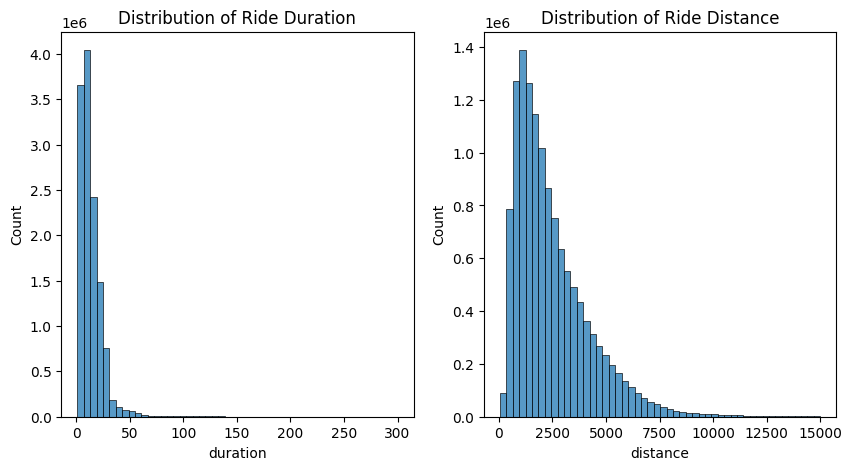

In [3]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
# Duration distribution
sns.histplot(bike_df['duration'], bins=50, ax=ax[0])
ax[0].set_title('Distribution of Ride Duration')
# Distance distribution
sns.histplot(bike_df['distance'], bins=50, ax=ax[1])
ax[1].set_title('Distribution of Ride Distance')
plt.show()


**Insight:** Most rides are short in both duration and distance
- Duration: ~95 % of trips under 30 minutes, with very few exceeding 1 hour.
- Distance: most trips are slightly over 1 km, but a heavier tail shows that some user make longer trips within the free timeframe.
- Policy effect: Trips reflect the pricing policy. Rides were with no additional pay up to 30 minutes until 2023, increasing to 1 hour in 2024.

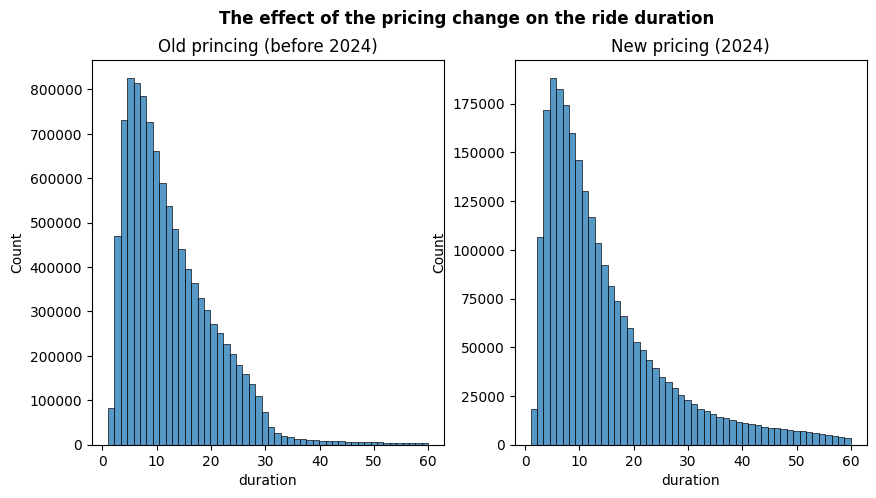

Pre-2024 trips > 30 min percentage:  0.033
2024 trips > 30 min percentage: 0.117


In [4]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
fig.suptitle("The effect of the pricing change on the ride duration", fontweight='bold')
sns.histplot(bike_df[(bike_df['duration'] < 60) & (bike_df.departure.dt.year < 2024)]['duration'], bins=50, ax=ax[0])
ax[0].set_title('Old princing (before 2024)')
sns.histplot(bike_df[(bike_df['duration'] < 60) & (bike_df.departure.dt.year == 2024)]['duration'], bins=50, ax=ax[1])
ax[1].set_title('New pricing (2024)')
plt.show()


pre_2024 = bike_df[bike_df['departure'].dt.year < 2024]
post_2024 = bike_df[bike_df['departure'].dt.year >= 2024]

print("Pre-2024 trips > 30 min percentage: ", round(len(pre_2024[pre_2024['duration'] > 30]) / len(pre_2024), 3))
print("2024 trips > 30 min percentage:", round(len(post_2024[post_2024['duration'] > 30]) / len(post_2024), 3))

**Insight:** The 2024 pricing policy change increased trips between 30 and 60 minutes.  
- Peak duration remains around 10 minutes, consistent with previous years.
- Trips over 30 minutes increased from ~3 % (2020-2023) to ~12 % in 2024, showing the effect of the new policy.
- Despite the increase, majority of the trips are still very short.

In [5]:
bike_df[['duration', 'distance']].corr()

,duration,distance
duration,1.000000,0.617957
distance,0.617957,1.000000


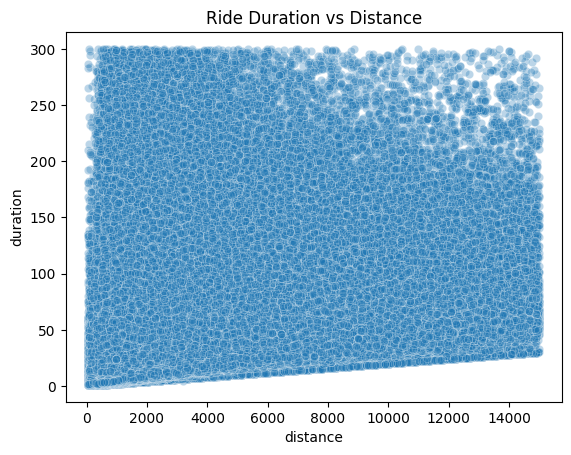

In [6]:
# Duration vs Distance scatterplot
sns.scatterplot(x='distance', y='duration', data=bike_df, alpha=0.3)
plt.title('Ride Duration vs Distance')
plt.show()

**Insight:** Duration and distance are moderately correlated (r ≈ 0.61), but the scatterplot shows no obvious linear pattern.
- The scatterplot is widely dispersed, showing high variation in riding speed.
- The minimum duration increases roughly linearly with distance, showing a physical constraint on travel time that longer trips cannot be extremely short.
- Variation above the minimum indicates differences between users, trip purpose (leisure vs commute) and traffic conditions.

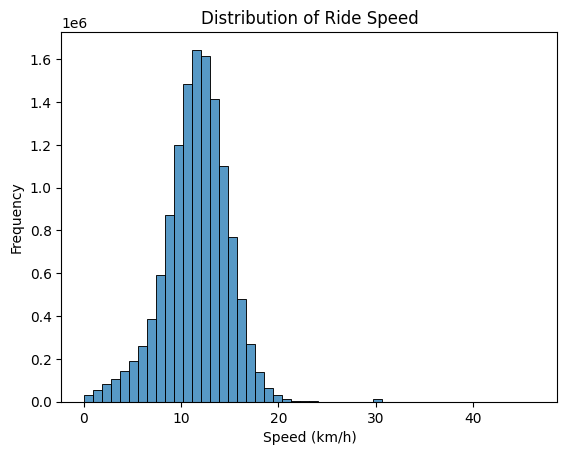

Number of rides: 12960378
Number of rides with speed > 20 km/h: 46872
Number of rides with speed > 30 km/h: 3720
Number of rides with speed > 40 km/h: 1


In [7]:
bike_df['speed'] = (bike_df['distance'] / 1000) / (bike_df['duration'] / 60)  # Speed in km/h
sns.histplot(bike_df['speed'], bins=50)
plt.title('Distribution of Ride Speed')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.show()

print("Number of rides:", round(len(bike_df)))
print("Number of rides with speed > 20 km/h:", round(len(bike_df[bike_df['speed'] > 20])))
print("Number of rides with speed > 30 km/h:", round(len(bike_df[bike_df['speed'] > 30])))
print("Number of rides with speed > 40 km/h:", round(len(bike_df[bike_df['speed'] > 40])))

**Insight:** Most users ride at moderate speeds.
- Most frequent speed is 10-13 km/h, with majority of rides under 20 km/h.
- Speeds under 10 km/h likely reflect stops, heavy traffic, or leisurely riding pace.
- Very few rides exceed 20 km/h, indicating that extremely fast trips are exceptionally rare.

### Temporal Usage Patterns

In [8]:
# Add date and time features
bike_df['year'] = bike_df['departure'].dt.year
bike_df['month'] = bike_df['departure'].dt.month
bike_df['weekday'] = bike_df['departure'].dt.day_of_week
bike_df['hour'] = bike_df['departure'].dt.hour
bike_df['is_weekend'] = bike_df['weekday'] >= 5

##### Yearly Usage

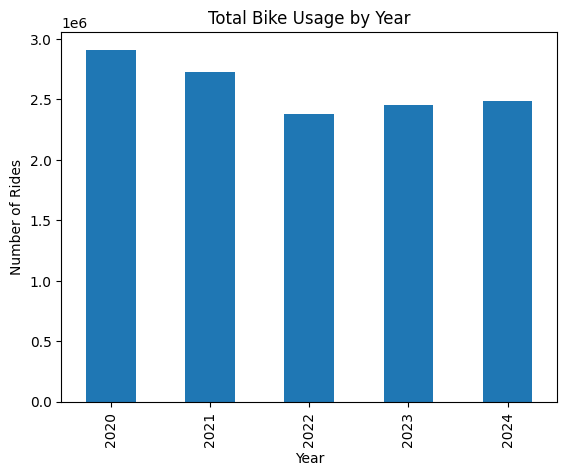

In [9]:
bike_df.groupby('year').size().plot(kind='bar')
plt.title('Total Bike Usage by Year')
plt.xlabel('Year')
plt.ylabel('Number of Rides')
plt.show()

Yearly trends in  the city bike usage.
- 2020 had the largest number of rides, followed by 2021.
- 2022 saw a significant drops in rides, with slight rebound in the following years, though the usage has not returned to pre-2022 levels.
- Price increase of the city bike pass and the growth of shared electric scooter services may have influenced usage. Full sources and context are provided in the README.

##### Monthly usage

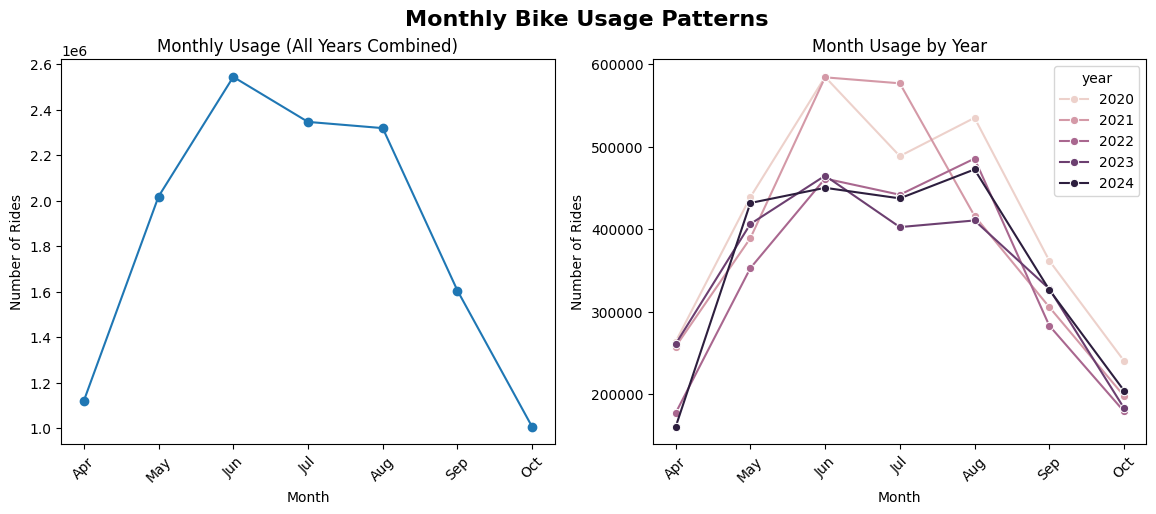

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Monthly Bike Usage Patterns", fontsize=16, fontweight='bold')

bike_df.groupby('month').size().plot(kind='line', marker='o', ax=axes[0])
axes[0].set_title('Monthly Usage (All Years Combined)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Rides')
axes[0].set_xticks(ticks=np.arange(4,11), labels=['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'], rotation=45)

monthly_usage = (
    bike_df.groupby(['year', 'month'])
    .size()
    .reset_index(name='ride_count')
)

sns.lineplot(
    data=monthly_usage,
    x='month',
    y='ride_count',
    hue='year',
    marker='o'
)
axes[1].set_xticks(ticks=np.arange(4,11), labels=['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'], rotation=45)
axes[1].set_title('Month Usage by Year')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Rides')
plt.show()

Monthly trends in the city bike usage.
- Usage highest during the summer months, peaking in June.
- Usage drops significantly in spring and autumn, indicating stronger demand in warmer months. 
- Patterns are consistent across years, with similar peaks and troughs, suggesting that seasonal factors have a stronger influence than year-to-year changes.
- Except for 2021, usage is higher in August than in July, possibly because July is a popular vacation month and fewer people are in the city to use the bikes.

##### Weekday Usage

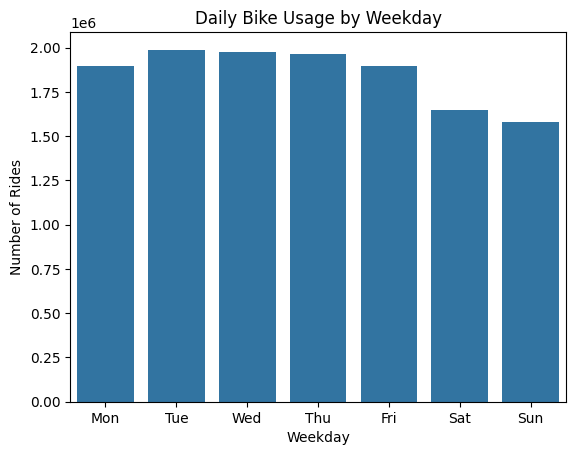

In [11]:
daily_usage = bike_df.groupby(['weekday']).size().reset_index(name='ride_count')
sns.barplot(
    data=daily_usage,
    x='weekday',
    y='ride_count',
)
plt.title('Daily Bike Usage by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Rides')
plt.xticks(ticks=np.arange(0, 7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

Weekday trends in city bike usage.
- Bike usage is highest on weekdays, with a Tuesday to Thursday slightly higher than Monday or Friday.
- Lower usage on Monday and Friday may reflect more remote work on those days. 
- Usage drops significantly on weekends, indicating that city bikes are primarily used for weekday commuting.

##### Hourly Usage

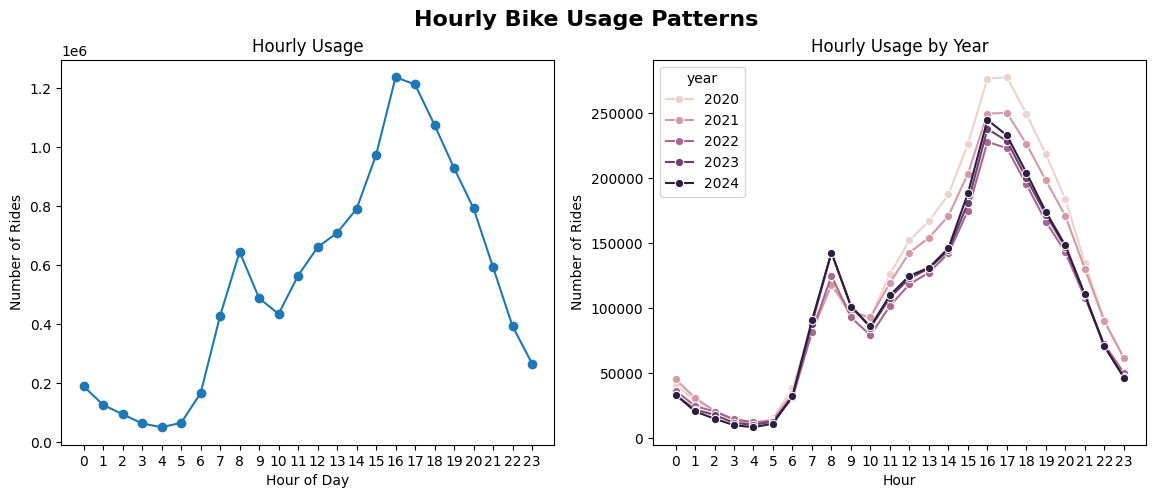

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Hourly Bike Usage Patterns", fontsize=16, fontweight='bold')

bike_df.groupby('hour').size().plot(kind='line', marker='o', ax=axes[0])
axes[0].set_title('Hourly Usage')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Rides')
axes[0].set_xticks(range(0,24))

daily_usage = bike_df.groupby(['year', 'hour']).size().reset_index(name='ride_count')
sns.lineplot(
    data=daily_usage,
    x='hour',
    y='ride_count',
    hue='year',
    marker='o',
    ax=axes[1]
)
axes[1].set_xticks(np.arange(0,24))
axes[1].set_title('Hourly Usage by Year')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Number of Rides')
plt.show()

Hourly trends in the city bike usage.
- Highest demand occurs between 16:00 and 18:00, coinciding with the evening commute.
- Morning peak around 08:00 reflects commuting to work or school.  
- Usage starts to increase steadily after 10:00, leading up to the evening peak. 
- Lowest usage is around 04:00.
- Pattern is consistent across years.

*Note: Each hour represents rides starting in that hour (e.g., 16 = 16:00–16:59).*

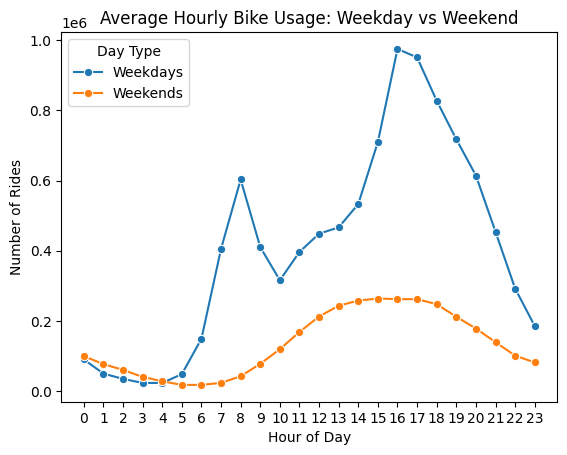

In [13]:
# Group by day_type and hour
hourly_usage = bike_df.groupby(['is_weekend', 'hour']).size().reset_index(name='rides')

# Plot
ax = sns.lineplot(data=hourly_usage, x='hour', y='rides', hue='is_weekend', marker='o')
plt.title('Average Hourly Bike Usage: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))

handles, labels = ax.get_legend_handles_labels()
new_labels = ['Weekdays', 'Weekends']
plt.legend(handles, new_labels, title='Day Type')
plt.show()

**Insight:** Daily usage patterns differ between weekdays and weekends.
- On weekdays, usage follows typical working hours, with a morning peak before work and a larger, wider peak in the late afternoon/early evening after work.  
- On weekends, peaks are wider but lower, with more balanced usage during the middle of the day and afternoon, indicating more leisure-oriented trips.

### Spatial analysis

##### Top stations

In [14]:
# Get the deaprture station counts
station_departure_counts = (
    bike_df.groupby(['departure_name', 'departure_lat', 'departure_lon'])
    .size()
    .reset_index(name='departures')
    .rename(columns={'departure_name': 'station', 'departure_lat': 'lat', 'departure_lon': 'lon'})
)

# Get the return station counts
station_return_counts = (
    bike_df.groupby(['return_name', 'return_lat', 'return_lon'])
    .size()
    .reset_index(name='returns')
    .rename(columns={'return_name': 'station', 'return_lat': 'lat', 'return_lon': 'lon'})
)

# Merge departure and return station counts
station_counts = pd.merge(
    station_departure_counts,
    station_return_counts,
    on=['station', 'lat', 'lon'],
    how='outer'
).fillna(0)

# Calculate total trips
station_counts['total_trips'] = station_counts['departures'] + station_counts['returns']
station_counts = station_counts.sort_values(by='total_trips', ascending=False).reset_index(drop=True)

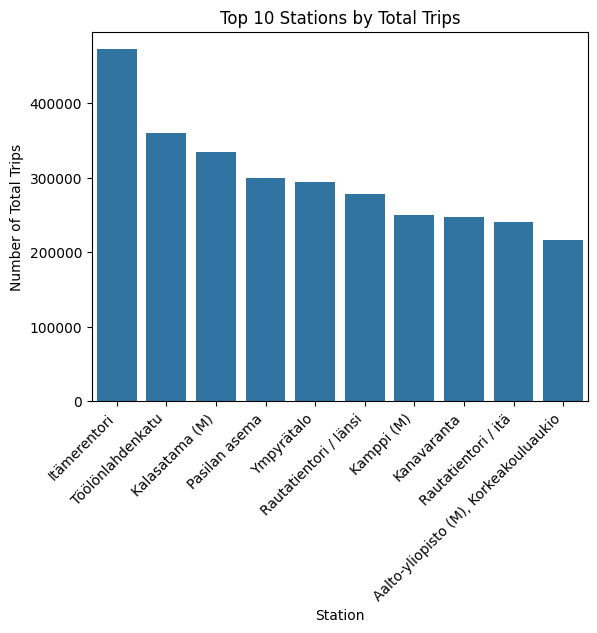

In [15]:
# Top stations bar plot
sns.barplot(data=station_counts.head(10), x='station', y='total_trips')
plt.title('Top 10 Stations by Total Trips')
plt.xlabel('Station')
plt.ylabel('Number of Total Trips')
plt.xticks(rotation=45, ha='right')
plt.show()

**Insight:** City bike usage is closely integrated with public transit. 
- Out of the top 10 most-used departure stations, 9 are located near ( $\leq$ 250 m) of metro stations and 4 of those are also close to major train stations. 
- This suggests that city bikes are commonly used as a first or last part of the commute.
- Proximity to metro and train stations was manually verified using HSL Journey Planner service.

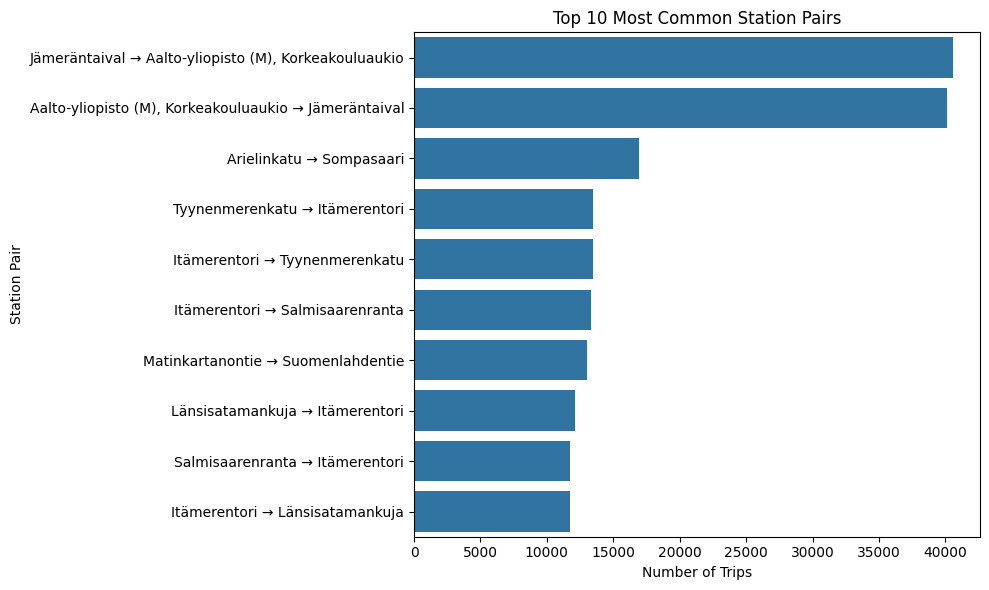

In [16]:
bike_df['station_pair'] = bike_df['departure_name'] + " → " + bike_df['return_name']
pair_counts = bike_df['station_pair'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    x=pair_counts.values,
    y=pair_counts.index,
)
plt.title('Top 10 Most Common Station Pairs')
plt.xlabel('Number of Trips')
plt.ylabel('Station Pair')

plt.tight_layout()
plt.show()

Most popular station pairs
- The pair **'Jämeräntaival' ↔ 'Aalto-yliopisto (M), Korkeakouluaukio'** is by far the most popular in both directions. 
- 6 out the remaining 8 tops pairs also appear bidirectionally, with **'Itämerentori'** included in all of these pairs. 
- **'Itämerentori'** is located close to a metro station, suggesting that it commonly used as a part of the commute from and to the metro.

##### Stations on a map

In [17]:
# City center coordinates
city_center_lat = 60.1699
city_center_lon = 24.9384

# Calculate quartile bins for ride counts
station_counts['usage_quartile'] = pd.qcut(station_counts['total_trips'], 4, labels=False)

# Map quartiles to colors
quartile_colors = {0: '#ffffb2', 1: '#fecc5c', 2: '#fd8d3c', 3: '#e31a1c'}



station_counts['color'] = station_counts['usage_quartile'].map(quartile_colors)

# Create a folium map centered on the Helsinki city center
m = folium.Map(location=[city_center_lat, city_center_lon], zoom_start=12)

# City center marker
folium.Marker(
    location=[city_center_lat, city_center_lon],
    popup="Helsinki City Center"

).add_to(m)

max_trips = station_counts['total_trips'].max()

# Plot departure stations
for _, row in station_counts[station_counts['lat'].notna()].iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=row['color'],
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['station']}: {row['total_trips']} trips"
    ).add_to(m)

# Add legend to the map
legend_html = """
<div style="position: fixed;
            bottom: 30px; left: 30px; width: 160px; height: 140px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
    <strong>Station Usage Quartiles</strong><br>
    <div style="background-color: #ffffb2; width: 10px; height: 10px; display: inline-block;"></div> Low Usage<br>
    <div style="background-color: #fecc5c; width: 10px; height: 10px; display: inline-block;"></div> Medium Usage<br>
    <div style="background-color: #fd8d3c; width: 10px; height: 10px; display: inline-block;"></div> High Usage<br>
    <div style="background-color: #e31a1c; width: 10px; height: 10px; display: inline-block;"></div> Very High Usage
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
m.save(CLEAN_DIR / 'station_map.html')
m

City bike station distribution and usage patterns.
- The map shows city bike stations in Helsinki and Espoo, with the Helsinki city center marked as a reference point.
- Stations form a dense cluster around the Helsinki city center (blue marker on the map), with the majority of the highest usage stations nearby.
- Usage decreases with distance from the city center, indicating that the proximity to the center is a key driver of bike demand. 

##### Most popular routes on a map

In [18]:
# Sort the station names per row to create a unique key for each station pair
stations_min = bike_df[['departure_name', 'return_name']].min(axis=1)
stations_max = bike_df[['departure_name', 'return_name']].max(axis=1)

# Create a pair key for each station pair
bike_df['pair_key'] = stations_min + " ↔ " + stations_max

# Aggregate the data by pair_key
pair_counts = bike_df.groupby('pair_key').size().reset_index(name='trip_count')
pair_counts = pair_counts.sort_values(by='trip_count', ascending=False).reset_index(drop=True)


stations_coords = bike_df[['departure_name', 'departure_lat', 'departure_lon']].drop_duplicates().set_index('departure_name')


# Create a folium map centered on the Helsinki city center
m = folium.Map(location=[city_center_lat, city_center_lon], zoom_start=12)

# Add lines for the top 20 station pairs
for _, row in pair_counts.head(20).iterrows():
    stations = row['pair_key'].split(" ↔ ")

    start_coords = stations_coords.loc[stations[0], ['departure_lat', 'departure_lon']].values
    end_coords = stations_coords.loc[stations[1], ['departure_lat', 'departure_lon']].values
    
    folium.PolyLine(
        locations=[start_coords, end_coords],
        color='blue',
        weight=2,
        opacity=0.6,
        popup=f"{row['pair_key']}: {row['trip_count']} trips"
    ).add_to(m)

m

Most popular city bike routes in Helsinki and Espoo.
- The map shows the top 20 most common station pairs, with lines connecting the departure and return stations.
- Some hub stations with multiple popular routes, suggesting proximity to other public transit stations.  
- One station in western Helsinki has several popular connections and is located next to a metro station.  
- Several routes are not connected with other popular routes, possibly indicating usage for traveling between different public transit stations. 

### Key Insights:
- Bikes are primarily used for short trips.
- Overall usage decreased after 2020 but has been slowly growing since 2022.
- Bike usage peaks during the summer months.
    - Highest usage in June.
- Weekday trends follow typical working hours.
    - Morning peak around 08:00 (commuting to work/school).
    - Larger evening peak between 16:00 and 18:00 (commuting home).
- Weekend usage patterns differ from weekday patterns.
    - The usage is lower in the weekends
    - More balanced usage throughout the day.
    - The peak is wider but lower compared to weekdays.
- A few stations dominate as the most popular departure and return points.
    - Some stations are located near metro or train stations, facilitating first/last mile commutes.
- The most popular stations are located near the Helsinki city center and close to metro and train stations.
- Popularity decreases as distance from the city center increases.


